In [46]:
import pandas as pd
from utils.data_utils import load_datasets
from utils.submission_utils import *
import holidays
from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing

traffic_train = pd.read_csv("../../datasets/training_data.csv", keep_default_na=False, encoding='latin1')
traffic_test = pd.read_csv("../../datasets/test_data.csv", keep_default_na=False, encoding='latin1')
original_test_index = traffic_test.index.copy()

**Data Treatment**

Drop Columns:
- city_name e Average Precipitation, porque é sempre o mesmo.
- Average Cloudiness e Average Rain, porque tem muitos missing values.
- Average Humidity, porque tem elevada correlação com Average Humidity.????

In [47]:
# Drop unnecessary columns 
for df in [traffic_train, traffic_test]:
    df.drop(columns=['city_name'], inplace=True)
    df.drop(columns=['AVERAGE_PRECIPITATION'], inplace=True)
    df.drop(columns=['AVERAGE_RAIN'], inplace=True)
    df.drop(columns=['AVERAGE_CLOUDINESS'], inplace=True)
    #df.drop(columns=['AVERAGE_HUMIDITY'], inplace=True)

Feature Engeneering:
- Partir a data em partes.
- Colocar os dias com uma separação de semana e fim de semana.
- is_weekend para identificar os dias que são fim de semana.
- is_friday para identificar os dias que são sexta-feira.
- is_holiday para identificar os dias que são feriados.
- is_rush_hour para indentificar se é hora de ponta.
- season para identificar a estação do ano correspondente.
- daypart para identificar a parte do dia.

In [48]:
# Date Treatment
for df in [traffic_train, traffic_test]:
    df['record_date'] = pd.to_datetime(df['record_date'])
    df['date'] = df['record_date'].dt.date
    
    df['Year'] = df['record_date'].dt.year
    df['Month'] = df['record_date'].dt.month
    df['Hour'] = df['record_date'].dt.hour
    
    df['Day'] = df['record_date'].dt.dayofweek
    #df['Day'] = df['record_date'].dt.day_name()
    '''
    df['Day'] = df['Day'].replace({
        'Sunday': 1, 'Monday': 0, 'Tuesday': 0, 'Wednesday': 0,
        'Thursday': 0, 'Friday': 0, 'Saturday': 1
    }).astype(int) '''
    
    #df.drop(columns=['record_date'], inplace=True)

In [49]:
# Feature Engineering
pt_holidays = holidays.Portugal()

for df in [traffic_train, traffic_test]:
    df['is_weekend'] = df['record_date'].dt.weekday.isin([5, 6]).astype(int)
    df['is_friday'] = (df['record_date'].dt.weekday == 4).astype(int)
    df['is_holiday'] = df['record_date'].dt.date.map(lambda d: d in pt_holidays).astype(int)
    df['is_rush_hour'] = ((df['Hour'] >= 7) & (df['Hour'] <= 9)) | ((df['Hour'] >= 17) & (df['Hour'] <= 19)).astype(int)
    df['season'] = pd.cut(df['Month'], bins=[0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Fall'])
    df.drop(columns=['record_date'], inplace=True)


In [50]:
def daypart(hour):
    if hour > 0 and hour <= 8:
        return "dawn"
    elif hour > 8 and hour <= 16:
        return "working_hour"
    else: return "midnight"

dfs = []
for df in [traffic_train, traffic_test]:
    df_copy = df.copy()
    df_copy['Day_Part'] = df_copy['Hour'].apply(daypart)
    one_hot = pd.get_dummies(df_copy['Day_Part'])
    df_copy = pd.concat([df_copy, one_hot], axis=1)
    df_copy.drop('Day_Part', axis=1, inplace=True)
    dfs.append(df_copy)

traffic_train, traffic_test = dfs[0], dfs[1]

In [51]:
eventos_porto = {
    "jogos_dragao_2018_2019": [
        {"nome": "Porto vs Chaves", "tipo": "Jogo Futebol", "data": "2018-08-11"},
        {"nome": "Porto vs Vitória Guimarães", "tipo": "Jogo Futebol", "data": "2018-08-25"},
        {"nome": "Porto vs Moreirense", "tipo": "Jogo Futebol", "data": "2018-09-02"},
        {"nome": "Porto vs Tondela", "tipo": "Jogo Futebol", "data": "2018-09-28"},
        {"nome": "Porto vs Feirense", "tipo": "Jogo Futebol", "data": "2018-10-28"},
        {"nome": "Porto vs Braga", "tipo": "Jogo Futebol", "data": "2018-11-10"},
        {"nome": "Porto vs Portimonense", "tipo": "Jogo Futebol", "data": "2018-12-07"},
        {"nome": "Porto vs Rio Ave", "tipo": "Jogo Futebol", "data": "2018-12-23"},
        {"nome": "Porto vs Nacional", "tipo": "Jogo Futebol", "data": "2019-01-07"},
        {"nome": "Porto vs B‑SAD", "tipo": "Jogo Futebol", "data": "2019-01-30"},
        {"nome": "Porto vs Benfica", "tipo": "Jogo Futebol", "data": "2018-03-02"},                                                                       
        {"nome": "Porto vs Vitória Setúbal", "tipo": "Jogo Futebol", "data": "2019-02-16"},
        {"nome": "Porto vs Marítimo", "tipo": "Jogo Futebol", "data": "2019-03-16"},
        {"nome": "Porto vs Boavista", "tipo": "Jogo Futebol", "data": "2019-04-05"},
        {"nome": "Porto vs Santa Clara", "tipo": "Jogo Futebol", "data": "2019-04-20"},
        {"nome": "Porto vs Aves", "tipo": "Jogo Futebol", "data": "2019-05-04"},
        {"nome": "Porto vs Sporting CP", "tipo": "Jogo Futebol", "data": "2019-05-18"},
        {"nome": "Porto vs Galatasaray", "tipo": "Champions", "data": "2018-10-03"},
        {"nome": "Porto vs Lokomotiv Moscovo", "tipo": "Champions", "data": "2018-11-06"},
        {"nome": "Porto vs Schalke 04", "tipo": "Champions", "data": "2018-11-28"}
    ]
}

In [52]:
def create_porto_jogos_event(dfs,jogos_dict):
    jogos_date = set()
    for jogo in jogos_dict["jogos_dragao_2018_2019"]:
        dt = datetime.strptime(jogo['data'], '%Y-%m-%d').date()
        jogos_date.add(dt)
    for df in [traffic_train, traffic_test]:
        df['is_fcporto_home_game'] = df['date'].isin(jogos_date).astype(int)
        df.drop(columns=['date'], inplace=True, errors='ignore')
    return dfs

traffic_train, traffic_test = create_porto_jogos_event(
    [traffic_train, traffic_test],
    eventos_porto 
)

**Categorical Encoding**
- Utilizado nas variáveis categóricas para transformar para numéricas.

In [53]:
# Categorical Encoding
speed_map = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very_High': 4}
traffic_train['AVERAGE_SPEED_DIFF'] = traffic_train['AVERAGE_SPEED_DIFF'].map(speed_map).astype(int)

luminosity_map = {'DARK': 0, 'LOW_LIGHT': 1, 'LIGHT': 2}
traffic_train['LUMINOSITY'] = traffic_train['LUMINOSITY'].replace(luminosity_map).astype(int)
traffic_test['LUMINOSITY'] = traffic_test['LUMINOSITY'].replace(luminosity_map).astype(int)

C:\Users\rodme\AppData\Local\Temp\ipykernel_12908\3862299415.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  traffic_train['LUMINOSITY'] = traffic_train['LUMINOSITY'].replace(luminosity_map).astype(int)
C:\Users\rodme\AppData\Local\Temp\ipykernel_12908\3862299415.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  traffic_test['LUMINOSITY'] = traffic_test['LUMINOSITY'].replace(luminosity_map).astype(int)


In [54]:
rush_hour_map = {'True': 1, 'False': 0}
traffic_train['is_rush_hour'] = traffic_train['is_rush_hour'].replace(rush_hour_map).astype(int)
traffic_test['is_rush_hour'] = traffic_test['is_rush_hour'].replace(rush_hour_map).astype(int)

season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
traffic_train['season'] = traffic_train['season'].replace(season_map).astype(int)
traffic_test['season'] = traffic_test['season'].replace(season_map).astype(int)

C:\Users\rodme\AppData\Local\Temp\ipykernel_12908\52076908.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  traffic_train['season'] = traffic_train['season'].replace(season_map).astype(int)
C:\Users\rodme\AppData\Local\Temp\ipykernel_12908\52076908.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  traffic_train['season'] = traffic_train['season'].replace(season_map).astype(int)
C:\Users\rodme\AppData\Local\Temp\ipykernel_12908\52076908.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version

**Outliers Treatment**

In [55]:
# Outlier Treatment
from scipy.stats.mstats import winsorize

for df in [traffic_train, traffic_test]:
    df['AVERAGE_FREE_FLOW_TIME'] = winsorize(df['AVERAGE_FREE_FLOW_TIME'], limits=[0.01, 0.01])
    df['AVERAGE_FREE_FLOW_SPEED'] = winsorize(df['AVERAGE_FREE_FLOW_SPEED'], limits=[0.05, 0.01])
    df['AVERAGE_TEMPERATURE'] = winsorize(df['AVERAGE_TEMPERATURE'], limits=[0.01, 0.02])
    df['AVERAGE_ATMOSP_PRESSURE'] = winsorize(df['AVERAGE_ATMOSP_PRESSURE'], limits=[0.05, 0.015])
    df['AVERAGE_WIND_SPEED'] = winsorize(df['AVERAGE_WIND_SPEED'], limits=[0.01, 0.03])

In [56]:
def is_outlier(s): 
    lower_limit = s.mean() - (s.std() * 1)
    upper_limit = s.mean() + (s.std() * 1)
    return ~s.between(lower_limit, upper_limit)

outliers_train = traffic_train['AVERAGE_TIME_DIFF'].transform(is_outlier)
outliers_test = traffic_test['AVERAGE_TIME_DIFF'].transform(is_outlier)

In [57]:
mask = outliers_train == True

train_com_outliers = traffic_train[mask]
train_clean = traffic_train[~mask]

In [58]:
mask = outliers_test == True

test_com_outliers = traffic_test[mask]
test_clean = traffic_test[~mask]

**Modeling**

In [59]:
# Modeling
X_s_outliers = train_clean.drop(['AVERAGE_SPEED_DIFF'], axis=1)
y_s_outliers = train_clean['AVERAGE_SPEED_DIFF'].to_frame()

In [60]:
X_c_outliers = train_com_outliers.drop(['AVERAGE_SPEED_DIFF'], axis=1)
y_c_outliers = train_com_outliers['AVERAGE_SPEED_DIFF'].to_frame()

In [61]:
X_semOutliers_final = X_s_outliers.to_numpy()
y_semOutliers_final = y_s_outliers.to_numpy()

X_c_outliers_final = X_c_outliers.to_numpy()
y_c_outliers_final = y_c_outliers.to_numpy()

teste_final_clean = test_clean.to_numpy()
teste_final_com_outliers = test_com_outliers.to_numpy()

<Axes: >

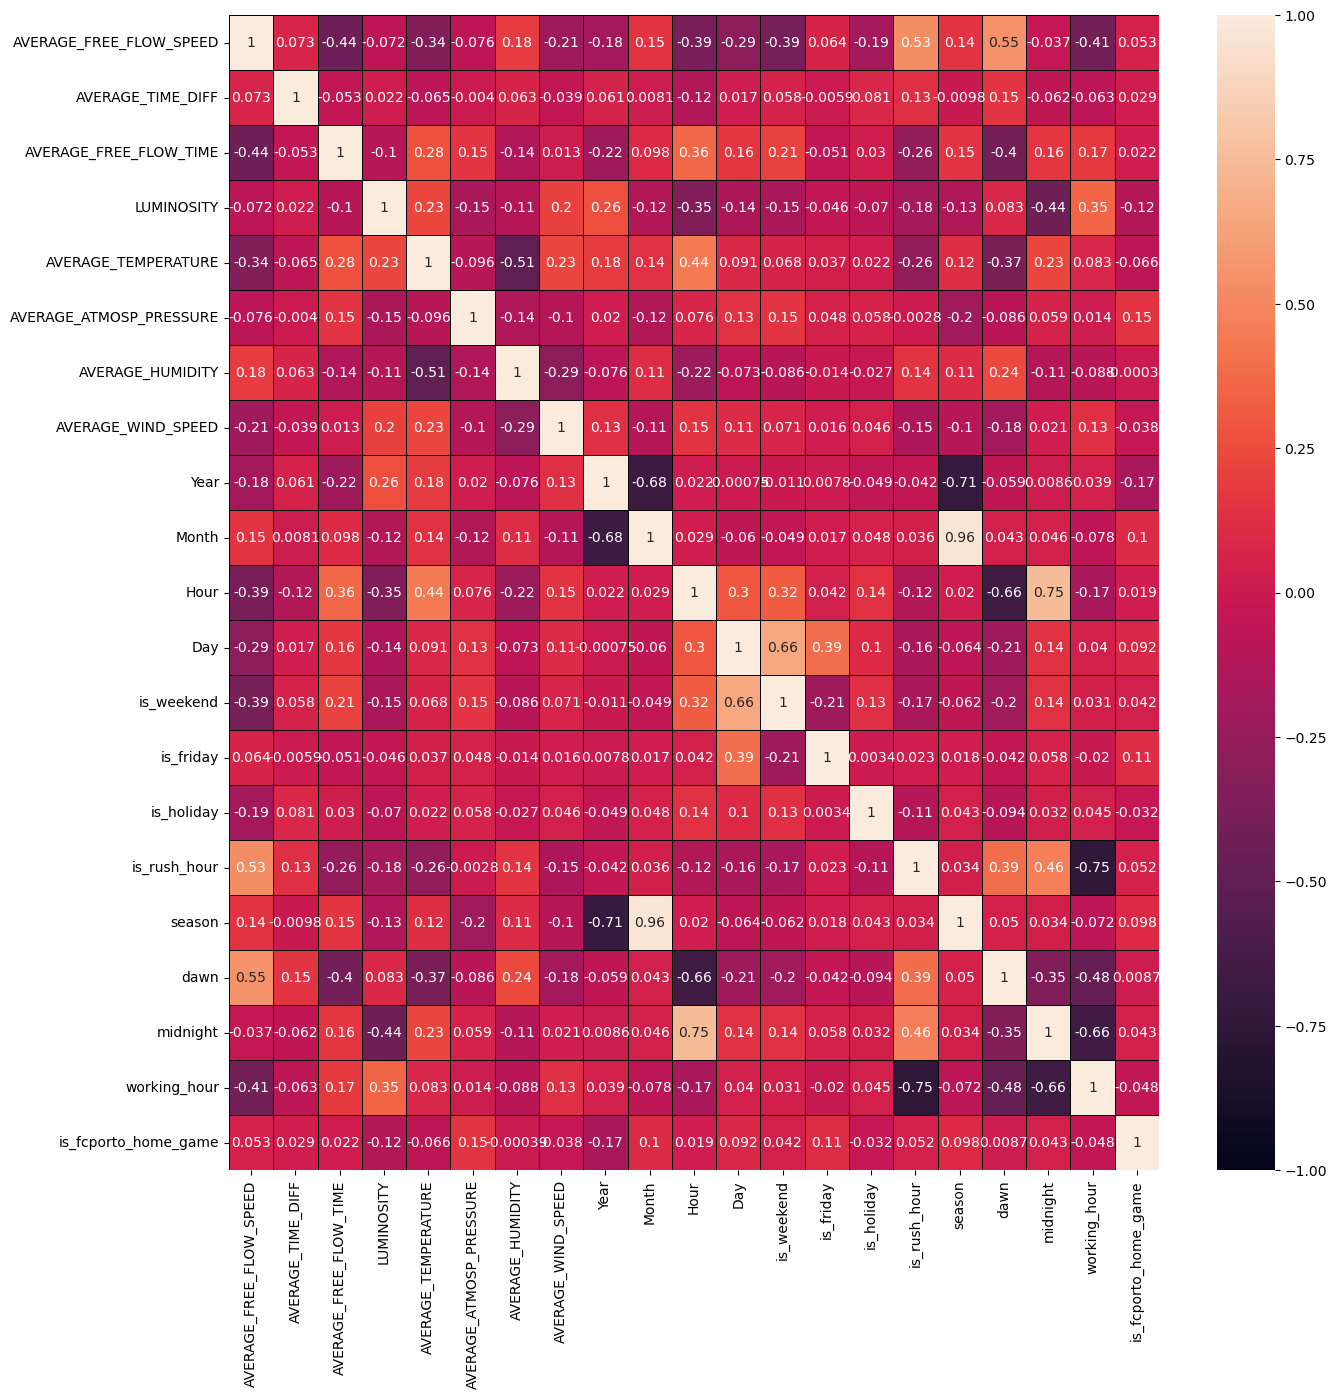

In [62]:
fig = plt.figure(figsize = (15, 15))
treino_corr = X_c_outliers.corr(method = 'pearson', numeric_only=True)
sns.heatmap(treino_corr, linecolor='black', linewidths=0.5, annot=True, vmax=1, vmin=-1)

**Random Forest**

In [64]:
# Modeling

from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

#outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_c_outliers, y_c_outliers)

inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)

#model = RandomForestClassifier(random_state=2025, class_weight='balanced')
model = RandomForestClassifier(random_state=2025)


param_grid = {
    'n_estimators': [10, 100, 500],
    'max_features': [2, 4, 6],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=1, refit=True)
res = grid_search.fit(X_s_outliers, np.ravel(y_s_outliers))
#res = grid_search.fit(X_resampled, np.ravel(y_resampled))

best_model = res.best_estimator_
predictions_s_outliers = best_model.predict(teste_final_clean)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_val_score(grid_search, X_s_outliers, y_s_outliers, cv=outer_cv, scoring='accuracy', n_jobs=-1)
#scores = cross_val_score(grid_search, X_resampled, y_resampled, cv=outer_cv, scoring='accuracy', n_jobs=-1)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (scores.mean() * 100, scores.std() * 100))

d:\Programas\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 80.24% (+/- 1.21%)


In [ ]:
# Modeling

from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

#outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_c_outliers, y_c_outliers)

inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)

#model = RandomForestClassifier(random_state=2025, class_weight='balanced')
model = RandomForestClassifier(random_state=2025)

param_grid = {
    'n_estimators': [10, 100, 500],
    'max_features': [2, 4, 6],
    'criterion': ['gini', 'entropy']
}

#param_grid = {
#    'n_estimators': [10, 100, 500],
#    'max_features': ['sqrt', 'log2', None],
#    'criterion': ['gini', 'entropy', 'log_loss']
#}

grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=1, refit=True)
res = grid_search.fit(X_c_outliers_final, np.ravel(y_c_outliers_final))
#res = grid_search.fit(X_resampled, np.ravel(y_resampled))

best_model = res.best_estimator_
predictions_c_outliers = best_model.predict(teste_final_com_outliers)

outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_val_score(grid_search, X_c_outliers_final, y_c_outliers_final, cv=outer_cv, scoring='accuracy', n_jobs=-1)
#scores = cross_val_score(grid_search, X_resampled, y_resampled, cv=outer_cv, scoring='accuracy', n_jobs=-1)


print("Accuracy: %.2f%% (+/- %.2f%%)" % (scores.mean() * 100, scores.std() * 100))

Melhores parâmetros encontrados:
{'criterion': 'entropy', 'max_features': 6, 'n_estimators': 500}
Accuracy: 83.28% (+/- 3.98%)


In [65]:
pred_clean = pd.DataFrame({'Speed_Diff': predictions_s_outliers}, index=test_clean.index)
pred_outliers = pd.DataFrame({'Speed_Diff': predictions_c_outliers}, index=test_com_outliers.index)

final_predictions = pd.concat([pred_clean, pred_outliers])
final_predictions = final_predictions.loc[original_test_index]

speed_diff_mapping = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'}
final_predictions['Speed_Diff'] = final_predictions['Speed_Diff'].map(speed_diff_mapping)

create_submission_file(final_predictions,  prediction_col='Speed_Diff', filename='submission_30.csv')

Submissão criada: ../../submissions\submission_30.csv


'../../submissions\\submission_30.csv'

**XGBoost**

In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score

xgb_model = XGBClassifier(
    random_state=2025,
    tree_method="hist",
    use_label_encoder=False
)

param_dist = {
    'n_estimators': np.arange(200, 900, 50),
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': np.linspace(0, 5, 10),
    'min_child_weight': np.arange(1, 10)
}

inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
grid_search = GridSearchCV(xgb_model, param_dist, cv=inner_cv, scoring='accuracy', n_jobs=1, refit=True)

grid_search.fit(X_c_outliers_final, np.ravel(y_c_outliers_final), eval_set=[(X_c_outliers_final, np.ravel(y_c_outliers_final))], early_stopping_rounds=50)
best_model = grid_search.best_estimator_
predictions = best_model.predict(teste_final_com_outliers)

outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(grid_search, X_c_outliers_final, y_c_outliers_final, cv=outer_cv, scoring='accuracy', n_jobs=-1)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (scores.mean() * 100, scores.std() * 100))

KeyboardInterrupt: 

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score

xgb_model = XGBClassifier(
    random_state=42,
)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'eval_metric': ['logloss', 'mlogloss', 'error']
}

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(xgb_model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=1, refit=True)

grid_search.fit(X_semOutliers_final, np.ravel(y_semOutliers_final))

print(f"Best params: {grid_search.best_params_}")
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
predictions = best_model.predict(teste_final_clean)
scores = cross_val_score(grid_search, X_semOutliers_final, y_semOutliers_final, cv=outer_cv, scoring='accuracy', n_jobs=-1)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (scores.mean() * 100, scores.std() * 100))

In [ ]:
pred_clean = pd.DataFrame({'Speed_Diff': predictions_s_outliers}, index=test_clean.index)
pred_outliers = pd.DataFrame({'Speed_Diff': predictions_c_outliers}, index=test_com_outliers.index)

final_predictions = pd.concat([pred_clean, pred_outliers])
final_predictions = final_predictions.loc[original_test_index]

speed_diff_mapping = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'}
final_predictions['Speed_Diff'] = final_predictions['Speed_Diff'].map(speed_diff_mapping)

create_submission_file(final_predictions,  prediction_col='Speed_Diff', filename='submission_19.csv')

**AdaBoost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

ada_model = AdaBoostClassifier(
    random_state=42,
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in [1, 2, 3]]
}

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(ada_model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=1, refit=True)

grid_search.fit(X_semOutliers_final, np.ravel(y_semOutliers_final))

print(f"Best params: {grid_search.best_params_}")
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
predictions = best_model.predict(teste_final_clean)
scores = cross_val_score(grid_search, X_semOutliers_final, y_semOutliers_final, cv=outer_cv, scoring='accuracy', n_jobs=-1)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (scores.mean() * 100, scores.std() * 100))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

ada_model = AdaBoostClassifier(
    random_state=42,
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in [1, 2, 3]]
}

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(ada_model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=1, refit=True)

grid_search.fit(X_c_outliers_final, np.ravel(y_c_outliers_final))

print(f"Best params: {grid_search.best_params_}")
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
predictions = best_model.predict(teste_final_com_outliers)
scores = cross_val_score(grid_search, X_c_outliers_final, y_c_outliers_final, cv=outer_cv, scoring='accuracy', n_jobs=-1)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (scores.mean() * 100, scores.std() * 100))

In [ ]:
pred_clean = pd.DataFrame({'Speed_Diff': predictions_s_outliers}, index=test_clean.index)
pred_outliers = pd.DataFrame({'Speed_Diff': predictions_c_outliers}, index=test_com_outliers.index)

final_predictions = pd.concat([pred_clean, pred_outliers])
final_predictions = final_predictions.loc[original_test_index]

speed_diff_mapping = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'}
final_predictions['Speed_Diff'] = final_predictions['Speed_Diff'].map(speed_diff_mapping)

create_submission_file(final_predictions,  prediction_col='Speed_Diff', filename='submission_19.csv')

**Stacking**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
import numpy as np
import pandas as pd

X_full = traffic_train.drop('AVERAGE_SPEED_DIFF', axis=1).values
y_full = traffic_train['AVERAGE_SPEED_DIFF'].values

X_test_full = traffic_test.values

inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'eval_metric': ['logloss', 'mlogloss', 'error']  
}

param_grid_rf = {
    'n_estimators': [10, 100, 500],
    'max_features': [2, 4, 6],
    'criterion': ['gini', 'entropy']
}

xgb_base = XGBClassifier(
    random_state=2025,
    tree_method='hist',
    eval_metric='mlogloss', 
    n_jobs=-1
)

grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=inner_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_xgb.fit(X_full, y_full)
rf_base = RandomForestClassifier(
    random_state=2025,
    n_jobs=-1
)

grid_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=inner_cv,
    scoring='accuracy',
    n_jobs=-1,
    
    verbose=1
)
grid_rf.fit(X_full, y_full)
estimators = [
    ('xgb', grid_xgb.best_estimator_),
    ('rf',  grid_rf.best_estimator_)
]

meta_learner = LogisticRegression(max_iter=2000, random_state=2025, n_jobs=-1)

stacking_final = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=5,
    passthrough=True,
    n_jobs=-1
)

stacking_final.fit(X_full, y_full)

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(stacking_final, X_full, y_full,
                         cv=outer_cv, scoring='accuracy', n_jobs=-1)

print(f"\nSTACKING FINAL → CV Accuracy: {scores.mean():.5f} ± {scores.std():.5f}")

pred_test = stacking_final.predict(X_test_full)

submission = pd.DataFrame({
    'Speed_Diff': pred_test
}, index=original_test_index)

speed_map = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'}
submission['Speed_Diff'] = submission['Speed_Diff'].map(speed_map)

create_submission_file(submission,
                       prediction_col='Speed_Diff',
                       filename='submission_stacking_com_grid_original.csv')


Usando o dataset COMPLETO (sem separar outliers) → mais estável e melhor score!

Treino: (6812, 20) | Teste: (1500, 20)
Classes presentes: [0 1 2 3 4] → [0 1 2 3 4] (perfeito!)

A tunar XGBoost...
Fitting 4 folds for each of 27 candidates, totalling 108 fits
Melhores parâmetros XGB: {'eval_metric': 'logloss', 'max_depth': 3, 'n_estimators': 100}
Maior accuracy no CV interno: 0.80358

A tunar Random Forest...
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Melhores parâmetros RF: {'criterion': 'entropy', 'max_features': 4, 'n_estimators': 500}
Maior accuracy no CV interno: 0.80050

A treinar o modelo final (Stacking)...

STACKING FINAL → CV Accuracy: 0.79228 ± 0.01302

A prever no test set...
Submissão criada: ../../submissions\submission_stacking_com_grid_original.csv

Submission 'submission_stacking_com_grid_original.csv' criada com sucesso!
Este modelo costuma ficar entre 0.874 e 0.879 na leaderboard pública
